In [1]:
!python --version

Python 3.10.12


# Towards spectral super-resolution in solar absorption lines from pseudomonochromatic images

## Experiment 1. Two-dimensional image regression with SIREN

This is a PyTorch implementation of the two-dimensional image regression experiment presented in the study ["Implicit Neural Representations
with Periodic Activation Functions"](https://www.vincentsitzmann.com/siren/) by Sitzmann et al.

### Choose envinroment, libraries and source files

#### Envinroment

In [2]:
# Attempt to import the necessary modules for Google Colab environment
try:
    # If running in Google Colab, import the drive module from google.colab
    from google.colab import drive
    # This mounts the Google Drive to the Colab VM, allowing access to its files.
    drive.mount('/content/drive')

    # Define the base path to the project folder within Google Drive
    PATH = '/content/drive/MyDrive/Colab Notebooks/FHN/assets/'
    # Concatenate the base path with specific subdirectories for source code, images, and outputs
    SRC_PATH = PATH + 'src/'  # Path to source code
    IMG_PATH = PATH + 'images/sol.h5'  # Path to a specific image file
    MODEL_PATH = PATH + 'outputs/models/SIREN2D/'  # Path to output models directory
    IMAGES_PATH = PATH + 'outputs/results/SIREN2D/images/' # Path to output images directory
    VIDEO_PATH = PATH + 'outputs/results/SIREN2D/videos/' # Path to output videos directory
    LOGS_PATH = PATH + 'outputs/results/SIREN2D/logs/' # Path to output log profiler directory

# If the google.colab module is not found (meaning not running in Google Colab),
# fallback to a local environment setup.
except ImportError:
    # Define local paths assuming the Jupyter Notebook is running in a local environment
    SRC_PATH = 'assets/src/'  # Local path to source code
    IMG_PATH = 'assets/images/sol.h5'  # Local path to a specific image file
    MODEL_PATH = 'assets/outputs/models/SIREN2D/'  # Local path to output models directory
    IMAGES_PATH = 'assets/outputs/results/SIREN2D/images/' # Path to output images directory
    VIDEO_PATH = 'assets/outputs/results/SIREN2D/videos/' # Path to output videos directory
    LOGS_PATH = 'assets/outputs/results/SIREN2D/logs/' # Path to output log profiler directory


Mounted at /content/drive


#### Libraries

In [3]:
# Import the 'sys' library to interact with the Python runtime environment.
import sys

# Import the 'copy' module from Python's standard library.
# This module provides the 'deepcopy' function, which can be used
# to create deep copies of mutable objects like dictionaries.
import copy

# Import the 'time' module to measure the time elapsed during certain operations or code execution
import time

# Import the NumPy library and rename it as np.
# NumPy is a library for numerical computing in Python and is especially useful for array operations.
import numpy as np

# Import the 'tqdm' function from the 'tqdm.auto' module for displaying progress bars in Jupyter notebooks or consoles.
from tqdm.auto import tqdm

# Import the pyplot module from the Matplotlib library and rename it as plt.
# Matplotlib is a library for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Import the 'seaborn' library for data visualization. Seaborn is based on Matplotlib
# and provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn

# Import the PyTorch library for deep learning.
# PyTorch is an open-source machine learning library used for a variety of tasks,
# including classification, regression, and image generation.
import torch

# Import the functional module from nn and rename it as F.
# This module contains functions that can be used in defining operations of a neural network,
# such as activations and losses.
import torch.nn.functional as F

# Importing necessary modules from torchvision.transforms
# Compose: Composes several transforms together into a single transform
# Normalize: Normalizes a tensor image with mean and standard deviation
from torchvision.transforms import Compose, Normalize

#### Source files

In [4]:
# Append the SRC_PATH directory to the system path to make its modules accessible.
sys.path.append(SRC_PATH)

In [5]:
# Import specific utility functions for tasks such as setting a random seed, smoothing curves,
# retrieving and processing data, plotting, cropping images, formatting time, feature scaling, and displaying information.
from utils import set_seed, smooth_curve, get_data, get_experiment_data, plot_data, crop, time_formatter, feat_scaling, info

# Import dataset manipulation functions for creating 3D grids and splitting 2D data.
from dataset import grid3D, split_data_2D

# Import training-related functions including the main training loop, function to generate B matrices,
# and the Fourier feature mapping function.
from training import train, generate_B, fourier_mapping

# Import the Neural Field model with SIREN (Sinusoidal Representation Networks) implementation.
from models import NeuralFieldSiren

### Random seed for reproducibility

In [6]:
# Set the random seed to 42 for reproducibility.
seed = 42
set_seed(seed)

### Get the available device

#### Minimum Recommended Hardware Requirements

To perform the training within an acceptable time frame, it is highly recommended to have access to a GPU. The original experiment was conducted using the following GPU configuration:

- **CUDA Availability**: Yes
- **GPU Model**: Tesla T4
- **Total Memory**: 15360.0 MiB
- **Free Memory**: 11392.0 MiB
- **Memory Used**: 3709.0 MiB
- **Timestamp**: Tue Aug 1 07:29:13 2023

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   3709MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
```

In [7]:
model = !nvidia-smi --query-gpu=name --format=csv,noheader
GPU = model[0]

In [8]:
# Define the 'device' variable to specify where the code will run (CPU or GPU).
# Use the GPU (CUDA) if available; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the available device to inform the user.
# This is useful for debugging and to ensure the code is running on the desired device.
print("Available device:", device)

Available device: cuda


### Solar images

<p align='justify'>For the PFG, we have a real spectral data cube I(x, y, λ) of the photospheric absorption line of neutral iron (that is, non-ionized) centered at 6302 Å (Fe I λ6302). Specifically, there are 21 pseudomonochromatic images, each with dimensions of 966x964 pixels, covering a large area of the Sun's surface. These images "scan" the Fe I λ6302 absorption line across 21 narrow wavelength (λ) intervals.</p>

In [9]:
# Call the 'get_data' function to read the image data from the specified path and store it in the variable 'cube'.
cube = get_data(IMG_PATH)

# Get the number of images in the cube by accessing the first dimension of its shape.
NUM_IMAGES = cube.shape[0]

# Create labels for the wavelengths. The labels are in the format 'λ = n', where n starts from 1 and goes up to NUM_IMAGES.
wl_lbls = [f'$\\lambda_{{{label + 1}}}$' for label in np.arange(0, NUM_IMAGES)]

First key: cube


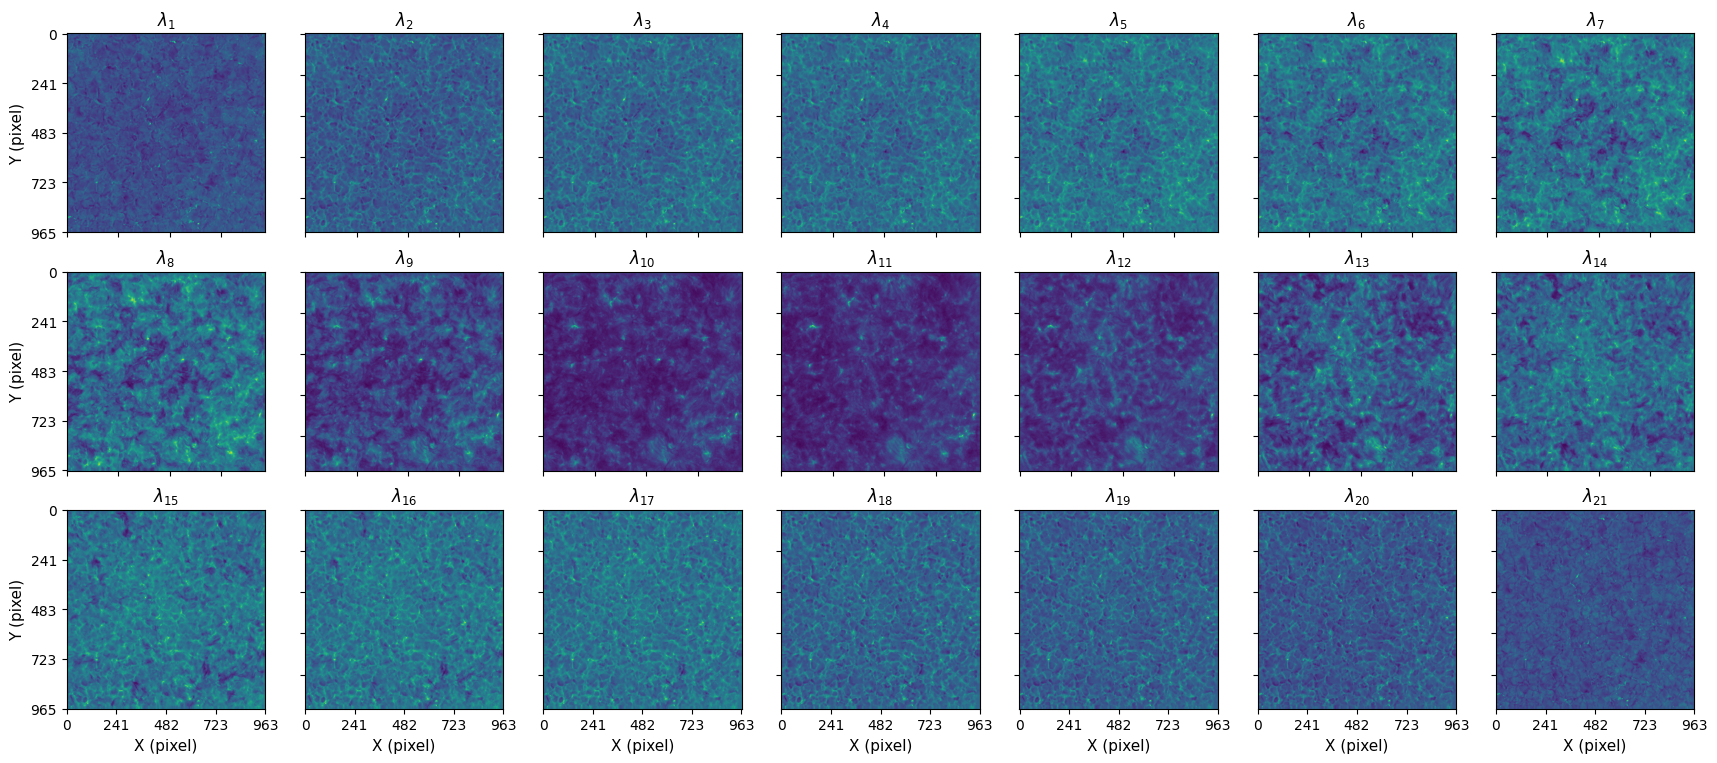

In [10]:
# Call the plot_data function to visualize the 'cube' dataset
plot_data(dataset=cube, num_columns=7,
          labels=wl_lbls, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='solar_dataset',
          hspace=0.1, wspace=0.2)


### Experiment Settings

#### Paremeters

In [11]:
# Define a list of loss functions to be used in the training process.
# The list includes L1 loss, MSE loss, and Smooth L1 loss.
loss_functions = [F.l1_loss, F.mse_loss, F.smooth_l1_loss]

# Initialize lists to store different values for the omega_0 parameter in SIREN.
# omega_0 is the frequency factor that multiplies the activations before the nonlinearity in the first layer.
# Different values of omega_0 can affect the model's ability to represent high-frequency functions.
omega_0 = [10., 30., 50., 100.]

# Initialize lists to store different values for the hidden_omega_0 parameter in SIREN.
# hidden_omega_0 is the frequency factor for the hidden layers in the SIREN model.
# Different values can affect how well the hidden layers capture the details of the function being approximated.
hidden_omega_0 = [10., 30., 50., 100.]

In [12]:
# Comment this two lines for complete training or uncomment for single training
# omega_0 = [30.]
# hidden_omega_0 = [30.]

In [13]:
# Initialize an empty dictionary to store the configuration parameters for the experiment.
config = {}

# Store the hardware information (either CPU or GPU details) in the 'info' key of the config dictionary
config['HARDWARE'] = info()

# Set index array of the images to be used from the data cube.
config['IMG_INDEX'] = [11]

# Set the size of the image crop to be used for training.
config['CROP_SIZE'] = 512

# Set the 'OMEGA' key. This value will be used as the frequency factor for the first layer in the SIREN model.
# config['OMEGA'] = omega_0[2]
config['OMEGA'] = omega_0[0]

# Set the 'HIDDEN_OMEGA' key. This value will be used as the frequency factor for the hidden layers in the SIREN model.
# config['HIDDEN_OMEGA'] = omega_0[2]
config['HIDDEN_OMEGA'] = omega_0[0]

# Set the learning rate for the optimizer.
config['LR'] = 1e-4

# Set the loss function to be used for training.
config['LOSS'] = loss_functions[1]

# Set the number of epochs for training.
config['EPOCHS'] = 2000

#### SIREN (SInusoidal REpresentation Networks)

In our experiment, we also explore the use of SIREN, a neural network architecture that employs sinusoidal activation functions to represent complex functions and signals. SIREN is particularly well-suited for representing high-frequency details, making it an excellent choice for tasks that require fine-grained reconstructions or approximations.

The key innovation in SIREN is the use of sinusoidal activation functions in the form of $\sin(\omega \mathbf{W} \mathbf{x} + \mathbf{b})$, where $\omega$ is a frequency parameter, $\mathbf{W}$ is the weight matrix, and $\mathbf{b}$ is the bias vector. The frequency parameter $\omega$ is crucial for controlling the expressiveness of the network. It allows SIREN to adapt to various scales and frequencies in the data.

#### SIREN Architecture in Our Experiment

In our implementation, the SIREN architecture consists of:

- An input layer that takes the pixel coordinates $(x, y)$ as input and applies a sinusoidal activation function with a frequency parameter $\omega_0$.
  
- Multiple hidden layers that also use sinusoidal activation functions, each with their own frequency parameter $\omega$.

- An output layer that produces the pixel intensity or RGB value for the given coordinates.

#### Frequency Parameters

For our experiment, we explore different frequency parameters $\omega_0$ for the input layer and $\omega$ for the hidden layers. Specifically, we investigate the following:

- Input layer frequency $\omega_0$: [10., 30., 100.]
  
- Hidden layer frequency $\omega$: [10., 30., 100.]

By incorporating SIREN into our neural field model, we aim to capture high-frequency details more effectively and improve the quality of the reconstructed or approximated images.

#### Obtaining the image for the experiment

In [14]:
# Retrieve one of the images from the cube dataset using the specified index from the config dictionary
images = get_experiment_data(cube, config['IMG_INDEX'])

# Crop the image to create a patch of size (CROP_SIZE x CROP_SIZE) as specified in the config dictionary
images = crop(images, config['CROP_SIZE'])

# Save GT image to config dictionary
config['GT_IMG'] = images

# Normalize the pixel intensity values of the image to the range [0, 1] using feature scaling
images, (min, max) = feat_scaling(images)

# Create an array of wavelengths ranging from config['IMG_INDEX'] array
wavelengths = np.array(config['IMG_INDEX'])

# Create labels for the wavelengths. The labels are in the format 'λ_n'
lbls = [f'$\\lambda_{{{label + 1}}}$' for label in wavelengths]

# Initialize a Compose object from torchvision.transforms to apply a sequence of transformations.
# In this case, the only transformation is Normalize,
# which normalizes the tensor with a mean of 0.5 and a standard deviation of 0.5.
# transform = Compose([
#  Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
# ])

# Apply the normalization transformation to tensor_norm.
# This will shift and scale the values in tensor_norm to be between -1 and 1.
# images = transform(images)

#### Obtaining the grid of normalized coordinates

In [15]:
# Obtain the grid of normalized coordinates in the interval [0, 1]
coords = grid3D(images)

# Save the grid to config dictionary
config['COORDS_VAL'] = coords

# Obtain the grid of normalized coordinates in the interval [-1, 1]
# coords = grid3D(data=images, ini_dim=-1)

#### Getting the training and test datasets

In [16]:
# Use the function to split the data into training and testing sets.
train_loader, test_loader = split_data_2D(coords, images, wavelengths, device=device)

# If using SolarFlatDataset, the tensors need to be reorganized
# The 'coords' and 'normalized_tensor' are permuted to match the expected input shape for SolarFlatDataset
# 'wavelengths' and 'device' are also passed as arguments to the data splitting function 'split_data_2D'
# 'ds_type=SolarFlatDataset' specifies that the SolarFlatDataset class should be used for handling the data
# train_loader, test_loader = split_data_2D(coords.permute(2, 3, 0, 1), normalized_tensor.permute(2, 3, 0, 1),
#                                           wavelengths, ds_type=SolarFlatDataset, device=device)

#### Info

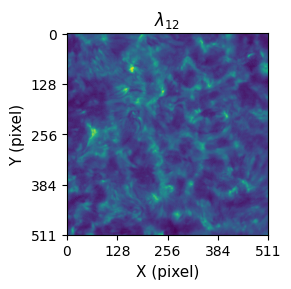

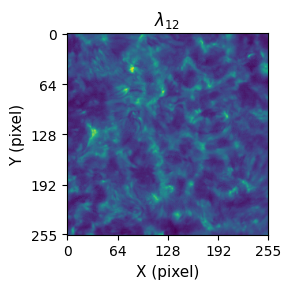

Coordinates: torch.Size([1, 3, 512, 512])
Image: torch.Size([1, 1, 512, 512])
Coordinates train: torch.Size([1, 3, 256, 256])
Image train: torch.Size([1, 1, 256, 256])
First batch coords: torch.Size([1, 3, 256, 256])
First batch labels: torch.Size([1, 1, 256, 256])


In [17]:
# Plot the image using the 'plot_data' function, squeezing and converting it to a NumPy array.
# Also, set the label size and font size for the plot.
plot_data(images.squeeze().numpy(), labels=lbls, tick_size=10,
          title_size=12, axis_size=11, path=IMAGES_PATH, img_name='test_data')

# Downsample the coordinates by taking every other pixel along the width and height.
coords_train = coords[:, :, ::2, ::2]

# Downsample the image by taking every other pixel along the width and height.
images_train = images[:, :, ::2, ::2]

# Plot the image_train using the 'plot_data' function, squeezing and converting it to a NumPy array.
# Also, set the label size and font size for the plot.
plot_data(images_train.squeeze().numpy(), labels=lbls, tick_size=10,
          title_size=12, axis_size=11, path=IMAGES_PATH, img_name='train_data')

# Print the shape of the original coordinates tensor.
print(f'Coordinates: {coords.shape}')

# Print the shape of the original image tensor.
print(f'Image: {images.shape}')

# Print the shape of the downsampled coordinates tensor.
print(f'Coordinates train: {coords_train.shape}')

# Print the shape of the downsampled image tensor.
print(f'Image train: {images_train.shape}')

# Retrieve the next batch of data and labels from the test_loader
x, y, _ = next(iter(train_loader))

# Print the shape of the batch data
print(f'First batch coords: {x.shape}')

# Print the shape of the batch labels
print(f'First batch labels: {y.shape}')

### Obtain an instance of the Neural Field model with SIREN

In [18]:
def instance_SIREN(lr=1, f0=30., h0=30., device='cpu'):
    """
    This function initializes an instance of a NeuralFieldSiren model along with an Adam optimizer.

    Parameters:
    - lr (float): The learning rate for the Adam optimizer. Default is 1.
    - f0 (float): The frequency parameter omega_0 for the input layer of the SIREN model. Default is 30.
    - h0 (float): The frequency parameter omega_0 for the hidden layers of the SIREN model. Default is 30.
    - device (str): The device ('cpu' or 'cuda') where the model will be deployed. Default is 'cpu'.

    Returns:
    - model (NeuralFieldSiren): An instance of the NeuralFieldSiren model.
    - optimizer (torch.optim.Adam): An instance of the Adam optimizer.
    """

    # Initialize the NeuralFieldSiren model with the given parameters
    model = NeuralFieldSiren(in_features=3, out_features=1, hidden_features=256,
                             first_omega_0=f0, hidden_omega_0=h0,
                             hidden_layers=3, outermost_linear=True).to(device)

    # Initialize the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Return the model and optimizer instances
    return model, optimizer


### Training routine function

In [19]:
def train_model(model, optimizer, config, train_loader, val_loader,
                process=False, base_dir=None, filename=None):

    # Record the start time for training
    start_time = time.time()

    #################################################################
    # Perform the training using the specified loss function,
    # optimizer, and other configurations
    output, best = train(model, optimizer,
                         config['LOSS'], config['EPOCHS'],
                         train_loader, val_loader, print_every=500,
                         device=device, process=process,
                         base_dir=base_dir, filename=filename)
    #################################################################

    # Record the end time for training
    end_time = time.time()

    # Calculate and store the total training time
    config['TRAINING_TIME'] = time_formatter(end_time - start_time)

    # Print the total training time
    print(f"Total training time: {config['TRAINING_TIME']}.")

    return output, best


### Training

In [20]:
# Initialize empty dics to store the trained models and their corresponding dictionaries
models = {}
dics = {}

# Loop through each value in the list of omega_0 frequencies
for omega in omega_0:
    # Update the configuration dictionary with the current omega value for both initial and hidden layers
    config['OMEGA'] = omega
    config['HIDDEN_OMEGA'] = omega
    print(f"ω = {config['OMEGA']}")

    # Create an instance of the SIREN model and its optimizer with the current omega and other configurations
    model, optimizer = instance_SIREN(lr=config['LR'], f0=omega, h0=omega,
                                      device=device)

    #process = True if omega==50.0 else False
    process = False

    base_dir = LOGS_PATH
    filename = f"{GPU}/ω={config['OMEGA']}"


    # Train the model and obtain the output metrics and the best model
    output, best = train_model(model, optimizer, config, train_loader,
                               test_loader, process, base_dir, filename)

    # Append a deep copy of the best model to the models list
    models[f'{omega}'] = copy.deepcopy(best)

    # Free the variable best after adding it to the models dictionary
    del best

    # Add a deep copy of the configuration used for this model to the 'best' dictionary
    output['config'] = copy.deepcopy(config)

    # Append the output metrics to the dics list
    dics[f'{omega}'] = output

    # Append the deep copy of the output metrics to the dics list
    # dics[f'{omega}'] = copy.deepcopy(output)

    # Free the memory allocated to output
    del output

ω = 10.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0058, test Loss: 0.0058
PSNR: 22.3796, test PSNR: 22.3752
Epoch 1000/2000, Loss: 0.0028, test Loss: 0.0028
PSNR: 25.4550, test PSNR: 25.4557
Epoch 1500/2000, Loss: 0.0016, test Loss: 0.0016
PSNR: 27.9766, test PSNR: 27.9729
Epoch 2000/2000, Loss: 0.0011, test Loss: 0.0011
PSNR: 29.5007, test PSNR: 29.4804
Total training time: 1.0 minute 54.84 seconds.
ω = 30.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0005, test Loss: 0.0005
PSNR: 33.3288, test PSNR: 33.3210
Epoch 1000/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 36.1167, test PSNR: 36.0620
Epoch 1500/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 36.9960, test PSNR: 36.9452
Epoch 2000/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 37.4458, test PSNR: 37.3340
Total training time: 1.0 minute 55.26 seconds.
ω = 50.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0003, test Loss: 0.0003
PSNR: 35.7202, test PSNR: 35.7006
Epoch 1000/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 38.0314, test PSNR: 37.8749
Epoch 1500/2000, Loss: 0.0001, test Loss: 0.0001
PSNR: 38.8383, test PSNR: 38.2497
Epoch 2000/2000, Loss: 0.0001, test Loss: 0.0001
PSNR: 39.6554, test PSNR: 38.5182
Total training time: 1.0 minute 47.52 seconds.
ω = 100.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 37.1499, test PSNR: 37.1034
Epoch 1000/2000, Loss: 0.0001, test Loss: 0.0001
PSNR: 39.5977, test PSNR: 38.7165
Epoch 1500/2000, Loss: 0.0000, test Loss: 0.0001
PSNR: 44.9660, test PSNR: 38.8353
Epoch 2000/2000, Loss: 0.0000, test Loss: 0.0001
PSNR: 48.1088, test PSNR: 38.3155
Total training time: 1.0 minute 55.41 seconds.


### Outputs

In [21]:
models['30.0']

NeuralFieldSiren(
  (model): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

#### Get the best generated images from each model

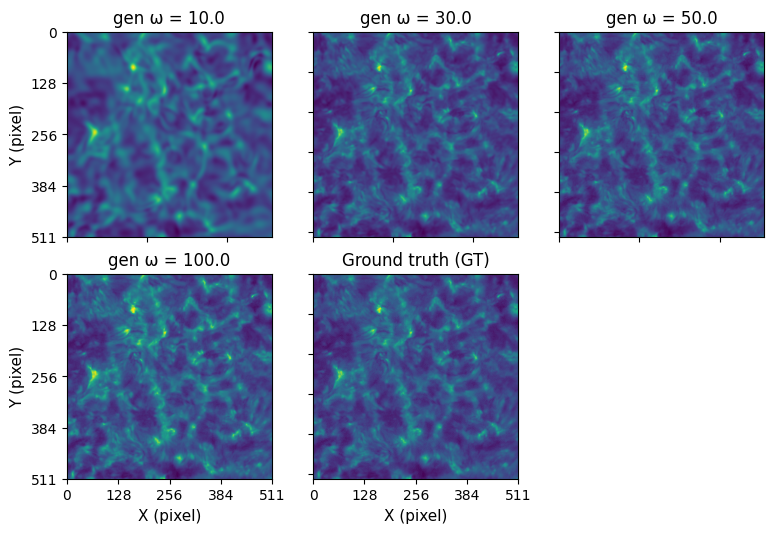

In [22]:
# Initialize empty lists to store the best generated images and their corresponding labels
best = []
labels = []

# Loop through the dictionary containing the output information for each Fourier feature mapping type
for s in dics:
    # Append the best generated image for the current SIREN model to the 'best' list
    best.append(dics[s]['best_test_generated'].detach().cpu())
    # Append the label (SIREN omega) to the 'labels' list
    labels.append(f"gen ω = {s}")

# Append the ground truth image to the 'best' list
best.append(images)
# Append the label 'Ground truth (GT)' to the 'labels' list
labels.append('Ground truth (GT)')

# Concatenate all the best generated images and the ground truth image along dimension 0
# Then, remove the singleton dimensions and convert the tensor to a NumPy array
generated_images = torch.cat(best, dim=0).squeeze().numpy()

# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=generated_images, num_columns=3,
          labels=labels, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT',
          hspace=0.1, wspace=0.2)

#### Graphical representation of metrics for the training and test sets

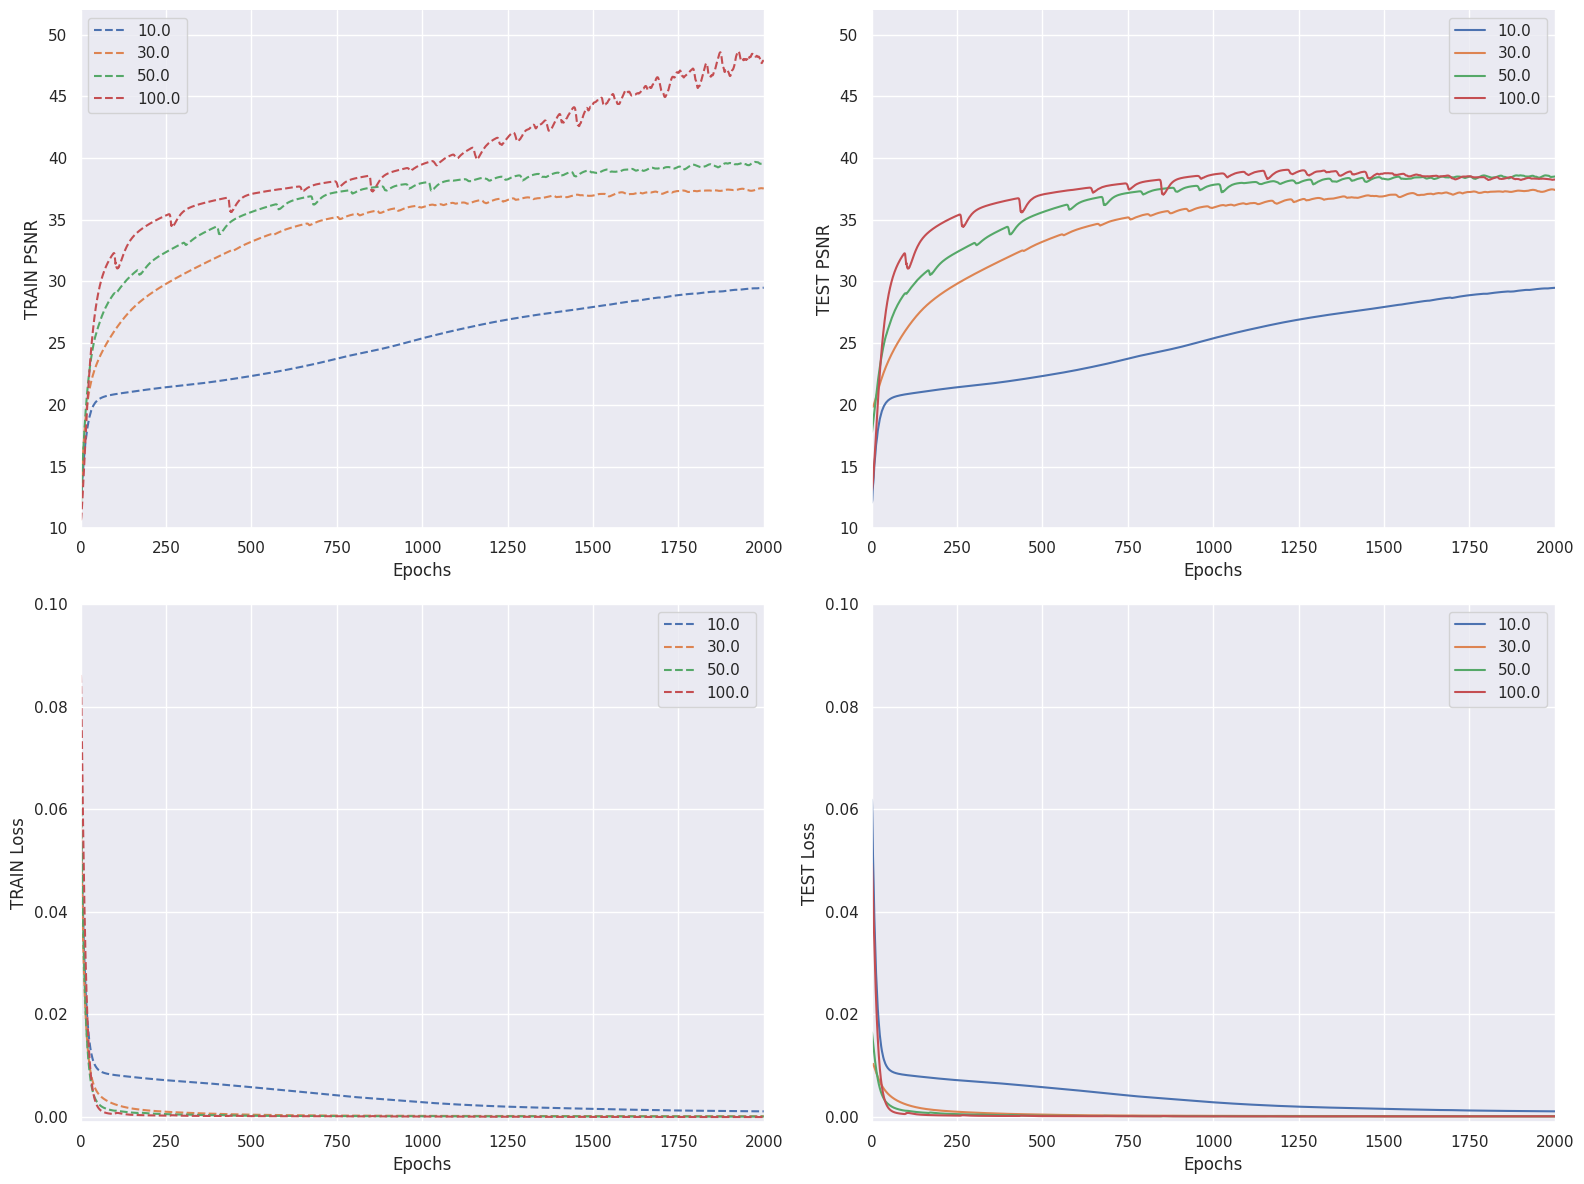

In [23]:
# from seaborn.relational import lineplot
# Set the Seaborn theme for better visualization
seaborn.set()
seaborn.set_theme()

# Create a figure and axes with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Generate x-values based on the number of epochs
xs = np.arange(1, config['EPOCHS'] + 1)

# Define metrics and their corresponding y-axis labels
metrics = ['psnr', 'test_psnr', 'loss', 'test_loss']
y_labels = ['TRAIN PSNR', 'TEST PSNR', 'TRAIN Loss', 'TEST Loss']

# Define y-axis limits for PSNR and Loss plots
y_limits = [(10, 52), (10, 52), (-0.001, 0.1), (-0.001, 0.1)]

# Loop through each subplot to plot the data
for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]  # Get the metric to be plotted for this subplot
    # Set the line style based on the subplot index (even or odd)
    if (i % 2 == 0):
        line = '--'  # Dashed line for even-indexed subplots
    else:
        line = '-'  # Solid line for odd-indexed subplots

    y_label = y_labels[i]  # Get the y-axis label for this subplot
    y_min, y_max = y_limits[i]  # Get the y-axis limits for this subplot

    # Plot the smoothed curve for each dictionary in 'dics'
    for k in dics:
        ax.plot(xs, smooth_curve(dics[k][metric], .9), label=k, linestyle=line)

    # Set subplot title, labels, and legend
    ax.set_title('')
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epochs')
    ax.legend()

    # Adjust the axis limits
    ax.set_xlim(left=0)
    ax.set_xlim(right=2000)
    ax.set_ylim(bottom=0)

    # Adjust the position of the axes to start at the origin
    ax.spines['left'].set_position('zero')
    # ax.spines['bottom'].set_position('zero')

    # Remove the top and right spines for better visualization
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Set the y-axis limits based on the predefined values
    ax.set_ylim(y_min, y_max)


# Adjust the spacing between the plots to avoid overlap
plt.tight_layout()

# Save the plot to a file. Choose the desired name and format.
plt.savefig(f'{IMAGES_PATH}Training_and_Validation_Metrics_Performance.png', dpi=150)

# Show the plots
plt.show()

# Reset the plot settings to default
plt.rcdefaults()

#### Save models

In [24]:
# Loop through each dictionary in 'dics' to save the corresponding model and dictionary
for i, s in enumerate(dics):
    # Save the model's state dictionary to a .pth file
    torch.save(models[s].state_dict(), MODEL_PATH + f"{i}_MODEL_SIREN2D_{s}_1.pth")

    # Save the entire dictionary to a .pth file
    torch.save(dics[s], MODEL_PATH + f"{i}_DIC_SIREN2D_{s}_1.pth")

#### Test Best Performance Model

In [25]:
# Initialize the NeuralFieldSiren model with specific parameters:
# - in_features: Set the number of input features to 3.
# - out_features: Set the number of output features to 1.
# - hidden_features: Specify the number of features in hidden layers as 256.
# - first_omega_0: Set the initial omega value for the first layer to 50.
# - hidden_omega_0: Set the omega value for hidden layers to 50.
# - hidden_layers: Define the number of hidden layers in the model as 3.
# - outermost_linear: Enable a linear output layer by setting this parameter to True.
siren_model = NeuralFieldSiren(in_features=3, out_features=1, hidden_features=256,
                               first_omega_0=50., hidden_omega_0=50.,
                               hidden_layers=3, outermost_linear=True)

# Load the model weights from a previously saved state dictionary, ensuring the model
# is mapped to the CPU memory space for compatibility across different environments.
siren_model.load_state_dict(torch.load(MODEL_PATH + '2_MODEL_SIREN2D_50.0_1.pth',
                                       map_location=torch.device('cpu')))

# Load a dictionary containing additional model information or metadata, such as training parameters
# or performance metrics, also ensuring it is mapped to the CPU.
siren_dic = torch.load(MODEL_PATH + '2_DIC_SIREN2D_50.0_1.pth',
                       map_location=torch.device('cpu'))


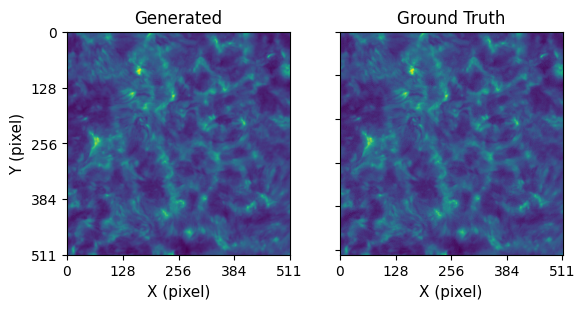

In [26]:
# Extract the configuration settings from the siren dictionary loaded earlier.
# This configuration likely contains model parameters, training settings, and other metadata.
config_siren = siren_dic['config']

# Set the model to evaluation mode. This is important because it tells the model to behave in inference mode,
# disabling specific layers or behaviors like dropout or batch normalization, which are only used during training.
siren_model.eval()

# Pass the selected image coordinates to the model to generate the output.
result = siren_model(config_siren['COORDS_VAL'])

# Concatenate `result` and `gt_image` along the batch dimension (dim=0)
# This assumes that `result` already has a shape of [1, C, H, W]
combined_images = torch.cat((result, config_siren['GT_IMG']), dim=0).detach().squeeze().numpy()

# Plotting the generated and ground truth images side by side for comparison.
plot_data(dataset=combined_images, num_columns=3,
          labels=['Generated', 'Ground Truth'], tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='comparison_generated_vs_ground_truth',
          hspace=0.1, wspace=0.2)


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import imageio

# Prepare the images and stamp information on them
converted_images = []
for idx, img in enumerate(siren_dic['history_images']):
    if idx % 5 == 0:
        # Remove batch dimension and convert to numpy for processing
        img = img.squeeze().detach().numpy()
        # Apply colormap
        img_mapped = plt.cm.viridis(img)
        # Convert to uint8
        img_mapped = (img_mapped[:, :, :3] * 255).astype(np.uint8)

        # Convert the numpy array to a PIL image object for editing
        pil_img = Image.fromarray(img_mapped)
        draw = ImageDraw.Draw(pil_img)

        # Optional: specify a font
        # font = ImageFont.truetype("arial.ttf", size=12)

        # Draw text (epoch number) in the top left corner
        # If font is omitted, PIL's default font is used
        lbl = idx + 5 if idx > 0 else 0

        draw.text((10, 10), f"Epoch {lbl}", fill="white")  # , font=font

        # Convert back to a numpy array to save in the video
        img_with_text = np.array(pil_img)
        converted_images.append(img_with_text)

# Save the processed images as a video
output_path = f'{VIDEO_PATH}/SIREN_learning_annotated.mp4'
imageio.mimwrite(output_path, converted_images, fps=20)


# Code to display the video in Jupyter Notebook (optional)
from IPython.display import HTML
from base64 import b64encode

# Read the video file and encode it for embedding in HTML
mp4 = open(output_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# Embed the video in the notebook
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
